# Create Denosing Model
This note book will use
- pytorch
- fashion_minst
to create a denosing UNet to be deployed on Alveo U50
To avoid size truncation during the test, we use cifar-10 32x32 instead 

In [136]:
import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


In [137]:
# check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [138]:
# Define constants
BATCH_SIZE = 64
EPOCHS = 20
NOISE_FACTOR = 0.2
LEARNING_RATE = 0.001

In [139]:
# Define transformations
transform = transforms.Compose([transforms.ToTensor()])

In [140]:
from torchvision import datasets, transforms

# 示例的 transform，适用于 CIFAR10
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # CIFAR10 是 RGB 图像
])

trainset = datasets.CIFAR10(root='0_data/', download=True, train=True, transform=transform)
testset = datasets.CIFAR10(root='0_data/', download=True, train=False, transform=transform)

trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True)

In [141]:
class Denoise(nn.Module):
    def __init__(self):
        super(Denoise, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 8, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        
        # Decoder - 输出范围 [-1, 1]
        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(8, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            
            nn.Conv2d(16, 3, kernel_size=3, padding=1),
            nn.Tanh()  # 关键修改：输出 [-1, 1]
        )
    
    def forward(self, x):
        orig_size = x.size()[2:]
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        
        if decoded.size()[2:] != orig_size:
            decoded = F.interpolate(decoded, size=orig_size, mode='bilinear', align_corners=False)
        
        return decoded


In [142]:
# Initialize the model, loss function, and optimizer
model = Denoise().float()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [143]:
# Function to add noise to images
def add_noise(images, noise_factor=NOISE_FACTOR):
    noise = noise_factor * torch.randn_like(images)  # 高斯噪声
    noisy_images = images + noise
    noisy_images = torch.clamp(noisy_images, -1., 1.)  # 保持 [-1, 1] 范围
    return noisy_images



In [144]:
def train(model, trainloader, device):
    model.train()
    model.to(device)
    train_loss = 0
    for images, _ in trainloader:
        images = images.to(device)
        noisy_images = add_noise(images).to(device)
        
        optimizer.zero_grad()
        outputs = model(noisy_images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    return train_loss / len(trainloader)

def test(model, testloader, device):
    model.eval()
    model.to(device)
    test_loss = 0
    with torch.no_grad():
        for images, _ in testloader:
            images = images.to(device)
            noisy_images = add_noise(images).to(device)
            outputs = model(noisy_images)
            loss = criterion(outputs, images)
            test_loss += loss.item()
    return test_loss / len(testloader)

In [145]:
# Training loop
# put the model on the device
# model = model.to(device)
for epoch in range(1, EPOCHS + 1):
    train_loss = train(model, trainloader, device)
    test_loss = test(model, testloader, device)
    print(f'Epoch [{epoch}/{EPOCHS}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')


Epoch [1/20], Train Loss: 0.0369, Test Loss: 0.0207
Epoch [2/20], Train Loss: 0.0191, Test Loss: 0.0180
Epoch [3/20], Train Loss: 0.0173, Test Loss: 0.0168
Epoch [4/20], Train Loss: 0.0161, Test Loss: 0.0156
Epoch [5/20], Train Loss: 0.0154, Test Loss: 0.0151
Epoch [6/20], Train Loss: 0.0149, Test Loss: 0.0149
Epoch [7/20], Train Loss: 0.0146, Test Loss: 0.0145
Epoch [8/20], Train Loss: 0.0144, Test Loss: 0.0142
Epoch [9/20], Train Loss: 0.0142, Test Loss: 0.0141
Epoch [10/20], Train Loss: 0.0140, Test Loss: 0.0141
Epoch [11/20], Train Loss: 0.0139, Test Loss: 0.0138
Epoch [12/20], Train Loss: 0.0138, Test Loss: 0.0139
Epoch [13/20], Train Loss: 0.0137, Test Loss: 0.0137
Epoch [14/20], Train Loss: 0.0137, Test Loss: 0.0139
Epoch [15/20], Train Loss: 0.0136, Test Loss: 0.0135
Epoch [16/20], Train Loss: 0.0135, Test Loss: 0.0134
Epoch [17/20], Train Loss: 0.0134, Test Loss: 0.0133
Epoch [18/20], Train Loss: 0.0134, Test Loss: 0.0137
Epoch [19/20], Train Loss: 0.0133, Test Loss: 0.0134
Ep

Original image shape: (32, 32, 3), type: float32, value range: 0.0 - 1.0
Noisy image shape: (32, 32, 3), type: float32, value range: 0.0 - 1.0
Denoised image shape: (32, 32, 3), type: float32, value range: 0.0 - 1.0
Original image shape: (32, 32, 3), type: float32, value range: 0.0 - 1.0
Noisy image shape: (32, 32, 3), type: float32, value range: 0.0 - 1.0
Denoised image shape: (32, 32, 3), type: float32, value range: 0.0 - 1.0
Original image shape: (32, 32, 3), type: float32, value range: 0.0 - 1.0
Noisy image shape: (32, 32, 3), type: float32, value range: 0.0 - 1.0
Denoised image shape: (32, 32, 3), type: float32, value range: 0.0 - 1.0
Original image shape: (32, 32, 3), type: float32, value range: 0.0 - 1.0
Noisy image shape: (32, 32, 3), type: float32, value range: 0.0 - 1.0
Denoised image shape: (32, 32, 3), type: float32, value range: 0.0 - 1.0
Original image shape: (32, 32, 3), type: float32, value range: 0.0 - 1.0
Noisy image shape: (32, 32, 3), type: float32, value range: 0.0

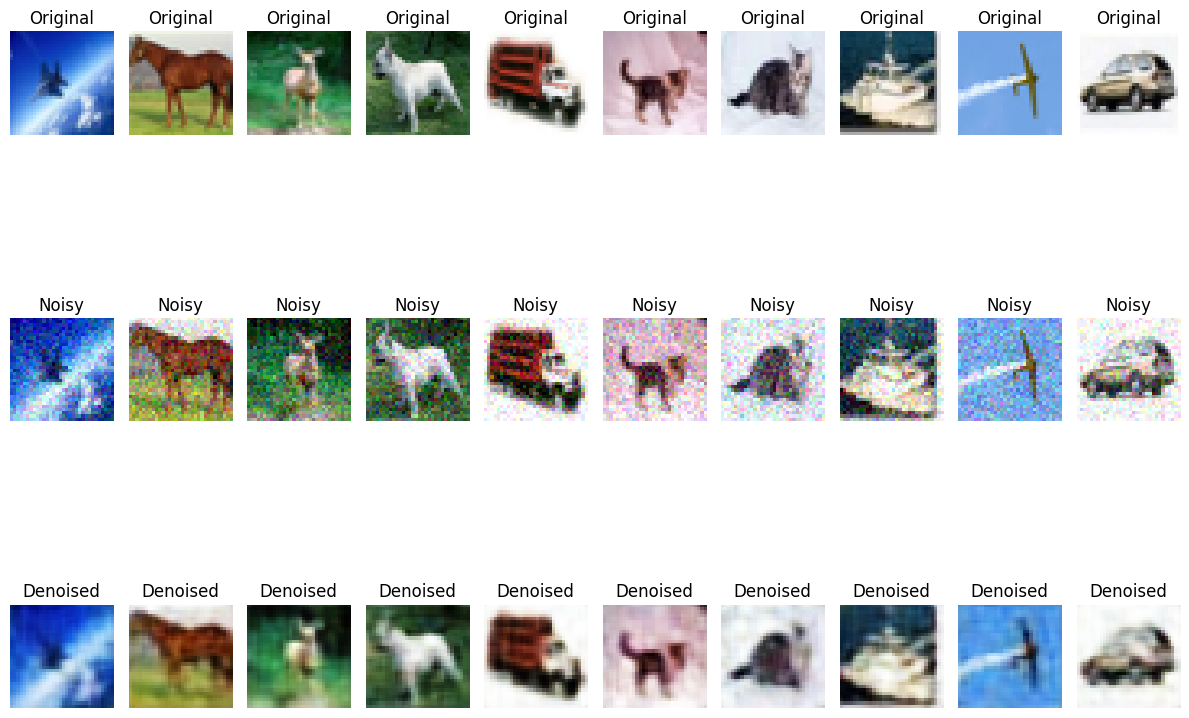

In [152]:
import matplotlib.pyplot as plt
import torch

# model back to CPU for visualization
model = model.to('cpu')

# Assuming dataiter, testloader, add_noise, and model are defined
dataiter = iter(testloader)
images, labels = next(dataiter)
noisy_images = add_noise(images)
outputs = model(noisy_images)

# Plot original, noisy, and denoised images
fig, axes = plt.subplots(3, 10, figsize=(12, 10))
for i in range(10):
    # Transpose images from (3, 32, 32) to (32, 32, 3) for RGB
    # Original images
    orig_img = images[i].permute(1, 2, 0).numpy()  # Change shape to (32, 32, 3)
    # map the values to [0, 1] range for visualization
    orig_img = (orig_img - orig_img.min()) / (orig_img.max() - orig_img.min())
    # print the shape and type and value range of the original image
    print(f"Original image shape: {orig_img.shape}, type: {orig_img.dtype}, value range: {orig_img.min()} - {orig_img.max()}")
    axes[0, i].imshow(orig_img)
    axes[0, i].set_title("Original")
    axes[0, i].axis('off')
    # save the original image to clean folder
    
    # Noisy images
    noisy_img = noisy_images[i].permute(1, 2, 0).numpy()  # Change shape to (32, 32, 3)
    # map the values to [0, 1] range for visualization
    noisy_img = (noisy_img - noisy_img.min()) / (noisy_img.max() - noisy_img.min())
    # print the shape and type of the noisy image
    print(f"Noisy image shape: {noisy_img.shape}, type: {noisy_img.dtype}, value range: {noisy_img.min()} - {noisy_img.max()}")
    #noisy_img = (noisy_img - noisy_img.min()) / (noisy_img.max() - noisy_img.min())  # Normalize for visualization
    axes[1, i].imshow(noisy_img)
    axes[1, i].set_title("Noisy")
    axes[1, i].axis('off')
    
    # Denoised images
    denoised_img = outputs[i].permute(1, 2, 0).detach().numpy()  # Change shape to (32, 32, 3)
    # map the values to [0, 1] range for visualization
    denoised_img = (denoised_img - denoised_img.min()) / (denoised_img.max() - denoised_img.min())
    # print the shape and type of the denoised image
    print(f"Denoised image shape: {denoised_img.shape}, type: {denoised_img.dtype}, value range: {denoised_img.min()} - {denoised_img.max()}")
    axes[2, i].imshow(denoised_img)
    axes[2, i].set_title("Denoised")
    axes[2, i].axis('off')

    # save all images to their corresponding folders under 3_output
    # if folder does not exist, create it
    import os
    output_dir = '3_output'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    clean_dir = os.path.join(output_dir, 'clean')
    noisy_dir = os.path.join(output_dir, 'noisy')
    denoised_dir = os.path.join(output_dir, 'denoised')
    if not os.path.exists(clean_dir):
        os.makedirs(clean_dir)
    if not os.path.exists(noisy_dir):
        os.makedirs(noisy_dir)
    if not os.path.exists(denoised_dir):
        os.makedirs(denoised_dir)
    # save images
    from torchvision.utils import save_image
    save_image(images[i], os.path.join(clean_dir, f'clean_{i}.png'))
    save_image(noisy_images[i], os.path.join(noisy_dir, f'noisy_{i}.png'))
    save_image(outputs[i], os.path.join(denoised_dir, f'denoised_{i}.png')) 
 

plt.tight_layout()
plt.show()

In [147]:
# Save the model to 1_model/
torch.save(model.state_dict(), '1_model/denoise_unet_cifar10_140_f32.pth', _use_new_zipfile_serialization=False )

In [148]:
# Save the onnx model as well
dummy_input = torch.randn(1, 3, 32, 32, dtype=torch.float32)
torch.onnx.export(model, dummy_input, '1_model/denoise_unet_cifar10_140_f32.onnx', 
                  input_names=['input'], output_names=['output'], 
                  dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}})
# Save the model to 1_model/ in ONNX format
print("Model saved to 1_model/denoise_unet_140_f32.pth and 1_model/denoise_unet_140_f32.onnx")

Model saved to 1_model/denoise_unet_140_f32.pth and 1_model/denoise_unet_140_f32.onnx


/tmp/ipykernel_64567/1193251439.py:32: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if decoded.size()[2:] != orig_size:
